# Building a multi-user ReAct AI Agent Chatbot with LangGraph - Prebuilt Agents

This demo will cover building AI Agents with LangGraph. We will use a pre-built agent but it should ease you into getting to grips with LangGraph

Agents are systems that use an LLM as a reasoning engine to determine which actions to take and what the inputs to those actions should be. The results of those actions can then be fed back into the agent and it determines whether more actions are needed, or whether it is okay to stop.

Here we'll create a simple ReAct agent app that can search the web and check the weather. The app consists of an agent (LLM) and tools. As we interact with the app, we will first call the agent (LLM) to decide if we should use tools. Then we will run a loop:

- If the agent said to take an action (i.e. call tool), we'll run the tools and pass the results back to the agent
- If the agent did not ask to run tools, we will finish (respond to the user)



In [1]:
!pip install langchain==0.2.0 --quiet
!pip install langchain-openai==0.1.7 --quiet
!pip install langchain-community==0.2.0 --quiet
!pip install langgraph==0.1.1 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 2.5 MB/s eta 0:00:00


In [2]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPEN_API_KEY')
os.environ['HUGGINGFACEHUB_API_TOKEN'] = userdata.get('HF_TOKEN')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')
WEATHER_API_KEY = userdata.get('WEATHER_API_KEY')

## Create Tools

Here we create two custom tools which are wrappers on top of the [Tavily API](https://tavily.com/#api) and [WeatherAPI](https://www.weatherapi.com/)

- Simple Web Search tool
- Weather tool

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
import json
import requests

tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

@tool
def search_web(query: str) -> list:
    """Search the web for a query."""
    results = tv_search.invoke(query)
    return results

@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather."""
    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={WEATHER_API_KEY}&q={query}"

    response = requests.get(complete_url)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"


## Test Tool Calling with LLM

In [4]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model="gpt-4o", temperature=0)
tools = [search_web, get_weather]

chatgpt_with_tools = chatgpt.bind_tools(tools)

In [5]:
prompt = "who won the champions league in 2024"
response = chatgpt_with_tools.invoke(prompt)
response.tool_calls

[{'name': 'search_web',
  'args': {'query': 'Champions League 2024 winner'},
  'id': 'call_9Wci2Sefcrb5FuMtBZifLbtX',
  'type': 'tool_call'}]

In [6]:
prompt = "how is the weather in Bangalore today"
response = chatgpt_with_tools.invoke(prompt)
response.tool_calls

[{'name': 'get_weather',
  'args': {'query': 'Bangalore'},
  'id': 'call_r2pzYiiVXD886Jj3HknS467C',
  'type': 'tool_call'}]

## Build and Test AI Agent with LangGraph Pre-built Agent

Now that we have defined the tools and the LLM, we can create the agent. We will be using a tool calling agent to bind the tools to the agent with a prompt. We will also add in the capability to store historical conversations as memory

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

SYS_PROMPT = """Act as a helpful assistant.
                Use the tools at your disposal to perform tasks as needed.
                  - get_weather: whenever user asks get the weather of a place.
                  - search_web: whenever user asks for information on current events or if you don't know the answer.
             """
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name="messages")
    ]
)

def add_sys_prompt(messages):
    return prompt_template.invoke({"messages": messages}).to_messages()


Now, we can initalize the agent with the LLM, the system prompt, and the tools.

The agent is responsible for taking in input and deciding what actions to take.

LangGraph will help us create a ReAct style agent with a built-in `create_react_agent` function. Please note that here we will use a prebuilt agent.

One of the big benefits of LangGraph is that you can easily create your own agent architectures. This is something we will look at in the next hands-on demos once you get familiar with some of the essentials of using LangGraph here.

Note that we are passing in the model `chatgpt`, not `chatgpt_with_tools`. That is because LangGraph will automatically bind the tools to the LLM under the hood using the `bind_tools` function.

This should ideally be used with an LLM which supports tool \ function calling

In [9]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(chatgpt, tools=tools,
                           messages_modifier=add_sys_prompt)

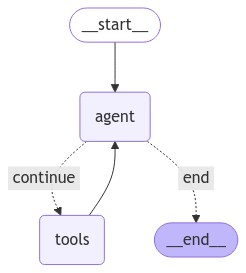

In [10]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [11]:
query = """Tell me who won the champions league in 2024,
            show some detailed information about the match also
        """
response = chatgpt.invoke(query)
response.content

"I'm sorry, but I don't have access to real-time data or events beyond October 2023. Therefore, I cannot provide information about the winner of the 2024 UEFA Champions League or details about the match. For the most current information, I recommend checking the latest sports news or the official UEFA website."

In [12]:
query = """Tell me who won the champions league in 2024,
            show some detailed information about the match also
        """
response = agent.invoke({"messages": [('user', query)]})

In [13]:
response

{'messages': [HumanMessage(content='Tell me who won the champions league in 2024,\n            show some detailed information about the match also\n        ', id='31a45900-ab5e-45b4-8bdc-6c44f3be23cf'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vYHmgl1Mcwqng1m4SNYo7OdU', 'function': {'arguments': '{"query":"Champions League 2024 winner"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 147, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-db96f41c-9848-47c8-92ac-a1b574433a4e-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'Champions League 2024 winner'}, 'id': 'call_vYHmgl1Mcwqng1

In [14]:
from IPython.display import display, Markdown

display(Markdown(response['messages'][-1].content))

The 2024 UEFA Champions League final was held at Wembley Stadium in London, England, on June 1, 2024. Real Madrid emerged victorious, defeating Borussia Dortmund with a score of 2-0. This victory marked Real Madrid's record-extending 18th European Cup/UEFA Champions League final appearance and their second in three years.

### Match Details:
- **Final Score**: Borussia Dortmund 0-2 Real Madrid
- **Location**: Wembley Stadium, London, England
- **Date**: June 1, 2024

### Additional Information:
- This was Borussia Dortmund's third UEFA Champions League final appearance, with their last appearance being in 2013.
- For Real Madrid, this final was significant as it marked the last club football match for their midfielder Toni Kroos, who made his sixth appearance in a Champions League final.
- Jude Bellingham from Real Madrid was named the Champions League Young Player of the Season.

Real Madrid's victory in this match allowed them to play against the winners of the 2023–24 UEFA Europa League, Atalanta, in the 2024 UEFA Super Cup.

In [15]:
query = """how is the weather in Bangalore today?
        """
response = agent.invoke({"messages": [('user', query)]})

In [16]:
query = """what have we discussed so far?
        """
response = agent.invoke({"messages": [('user', query)]})

In [17]:
display(Markdown(response['messages'][-1].content))

We haven't had any discussions yet. If you have any questions or need assistance, feel free to ask!

## Build and Test Multi-User Conversational ReAct AI Agent

We will now use `SqliteSaver` which helps to store separate conversation histories per user or session.

This will help us build a conversational Agentic Chatbot which will be accessed by many users at the same time.

While the legacy syntax uses `session_id`, in LangGraph, each user session is identified by `thread_id`

In [18]:
# removes the memory database file - usually not needed
# you can run this only when you want to remove ALL conversation histories
# ok if you get rm: cannot remove 'memory.db': No such file or directory  because initially no memory exists
!rm memory.db*

rm: cannot remove 'memory.db*': No such file or directory


In [19]:
from langgraph.checkpoint.sqlite import SqliteSaver

# used to retrieve conversation history from database
# based on a specific user or session ID
memory = SqliteSaver.from_conn_string("memory.db")

# create a conversation chain + agent which can load memory based on specific user or session id
agentic_chatbot = create_react_agent(chatgpt, tools=tools,
                                     checkpointer=memory,
                                     messages_modifier=add_sys_prompt)

# function to call the agent show results per user session (called a thread ID here)
from IPython.display import display, Markdown
def chat_with_agent(prompt: str, session_id: str):
    response = agentic_chatbot.invoke({"messages": [('user', prompt)]},
                                      {'configurable': { 'thread_id': session_id}})
    display(Markdown(response['messages'][-1].content))

In [20]:
user_id = 'john001'
prompt = "Tell me who won champions league in 2024"
chat_with_agent(prompt, user_id)

Real Madrid won the 2024 UEFA Champions League, defeating Borussia Dortmund 2-0 in the final held at Wembley Stadium in London.

In [21]:
prompt = "Tell me more about this event in detail please"
chat_with_agent(prompt, user_id)

The 2024 UEFA Champions League final was a significant event in European club football, held on June 1, 2024, at Wembley Stadium in London, England. Here are some key details about the event:

- **Teams**: The final was contested between Borussia Dortmund and Real Madrid. For Borussia Dortmund, this was their third appearance in a UEFA Champions League final, with their last appearance being in 2013. Real Madrid, on the other hand, was making their record-extending 18th appearance in a European Cup/UEFA Champions League final.

- **Match Outcome**: Real Madrid emerged victorious with a 2-0 win over Borussia Dortmund. This victory added another prestigious title to Real Madrid's illustrious history in European competitions.

- **Significant Players**: The match marked the last club football appearance for Real Madrid midfielder Toni Kroos, who made his sixth appearance in a Champions League final. Additionally, Jude Bellingham from Real Madrid was recognized as the Champions League Young Player of the Season.

- **Post-Match**: As winners of the Champions League, Real Madrid earned the right to play against Atalanta, the winners of the 2023–24 UEFA Europa League, in the 2024 UEFA Super Cup.

The event was a showcase of top-tier European football, with Real Madrid continuing their legacy as one of the most successful clubs in the history of the competition.

In [22]:
user_id = 'bond007'
prompt = "how is the weather in Bangalore today? Show detailed statistics"
chat_with_agent(prompt, user_id)

The current weather in Bangalore, Karnataka, India is as follows:

- **Temperature**: 22.3°C (72.1°F)
- **Condition**: Clear
- **Feels Like**: 24.5°C (76.1°F)
- **Wind**: 10.1 mph (16.2 kph) from the East-Southeast (ESE) at 101°
- **Pressure**: 1019.0 mb (30.09 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Humidity**: 69%
- **Cloud Cover**: 0%
- **Visibility**: 6.0 km (3.0 miles)
- **UV Index**: 0.0
- **Gusts**: Up to 17.1 mph (27.5 kph)
- **Dew Point**: 10.8°C (51.5°F)

The weather is clear with no cloud cover, and it's currently nighttime in Bangalore.

In [23]:
user_id = 'bond007'
prompt = "what about Dubai?"
chat_with_agent(prompt, user_id)

The current weather in Dubai, United Arab Emirates is as follows:

- **Temperature**: 25.1°C (77.2°F)
- **Condition**: Clear
- **Feels Like**: 26.9°C (80.3°F)
- **Wind**: 9.4 mph (15.1 kph) from the North (N) at 351°
- **Pressure**: 1015.0 mb (29.97 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Humidity**: 41%
- **Cloud Cover**: 0%
- **Visibility**: 10.0 km (6.0 miles)
- **UV Index**: 0.0
- **Gusts**: Up to 16.8 mph (27.1 kph)
- **Dew Point**: 17.5°C (63.4°F)

The weather is clear with no cloud cover, and it's currently nighttime in Dubai.

In [24]:
user_id = 'bond007'
prompt = "which city is hotter?"
chat_with_agent(prompt, user_id)

Currently, Dubai is hotter than Bangalore. The temperature in Dubai is 25.1°C (77.2°F), while in Bangalore, it is 22.3°C (72.1°F).